# Homework 3: Association Rules Solution

## 1  Evaluation Metrics (20 %)

### 1.1  

## 1a. 信賴度的限制是什麼？為何提升度與確信度不受此影響？

**信賴度 (Confidence)** 定義為：
\[
\text{conf}(A\rightarrow B) = P(B \mid A)
\]
它只考慮在 \( A \) 發生時 \( B \) 發生的機率，  
但**沒有考慮 \( B \) 自己本來就發生的可能性 \( P(B) \)**。

如果 \( B \) 原本就很常出現，即使 \( A \) 和 \( B \) 沒有很強的關聯，信賴度也可能很高，這會**誤導我們以為規則很強**。


### 1.2  

而：

- **提升度 (Lift)**：將信賴度除以 \( P(B) \)，修正了 \( B \) 出現很頻繁導致的假象。
- **確信度 (Conviction)**：比較「如果 \( A \) 發生但 \( B \) 沒發生」的理論次數與實際次數，也考慮了 \( P(B) \)，所以不受影響。

### 1.3 

---

## 1b. 這些指標有對稱性嗎？請逐一說明

> **對稱性 (Symmetry)**：若交換規則的前項與後項 (A⇔B)，指標值保持不變，則稱有對稱性。

| 指標 | 有對稱性嗎？ | 說明 |
| :--- | :--- | :--- |
| 信賴度 (Confidence) | ❌ 沒有 | 例子：\( P(A)=0.6 \)、\( P(B)=0.2 \)、\( P(A,B)=0.12 \)，則 \( \text{conf}(A\to B)=0.2 \)、\( \text{conf}(B\to A)=0.6 \)，不相等。 |
| 提升度 (Lift) | ✅ 有 | 計算式 \( \text{lift}(A\to B) = \frac{P(A,B)}{P(A)P(B)} \)，交換 A, B 結果不變。 |
| 確信度 (Conviction) | ❌ 沒有 | 同樣例子下，\( \text{conv}(A\to B) \) 和 \( \text{conv}(B\to A) \) 不相同，且在極端機率下差異更明顯。 |

---

### 1.4  

## 1c. 這些指標在完美隱含規則時能達到最大值嗎？

> **完美隱含規則**：當 \( P(B \mid A) = 1 \)，即每次 \( A \) 發生，\( B \) 一定也發生。

| 指標 | 能達到最大值嗎？ | 說明 |
| :--- | :--- | :--- |
| 信賴度 (Confidence) | ✅ 可以 | 最大值是 1。 |
| 提升度 (Lift) | ✅ 可以 | 當 \( \text{conf}=1 \)，提升度變為 \( 1/P(B) \)，隨 \( B \) 稀有而變大。 |
| 確信度 (Conviction) | ✅ 可以 | 當 \( \text{conf}=1 \)，確信度分母趨近 0，確信度趨向無限大。 |

所以，這三個指標在遇到完美隱含規則時，都可以「到達」各自的最大值，只是確信度會是無限大（∞）

## 2  Application in Recommending Items (30 %)

### 2.1  

In [11]:
!pip install mlxtend

In [12]:

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, fpgrowth
import itertools, time, os


In [13]:

# Load browsing data
DATA_PATH = r"C:\Users\ian32\Downloads\browsing.txt"
with open(DATA_PATH, 'r', encoding='utf-8') as f:
    transactions = [line.strip().split() for line in f if line.strip()]
print(f'Total transactions: {len(transactions)}')


Total transactions: 31101


In [14]:

# One‑hot encode the transaction data
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df = pd.DataFrame(te_ary, columns=te.columns_)
print(f'Total unique items: {df.shape[1]}')


Total unique items: 12592


In [15]:

# Validate |L1| at support >=100
min_count = 100
min_support = min_count / len(df)
l1 = apriori(df, min_support=min_support, use_colnames=True, max_len=1)
print(f'|L1| = {len(l1)} (expected 647)')


|L1| = 647 (expected 647)


In [16]:

# Helper functions
def build_support_dict(freq_df):
    total_tx = len(df)
    return {frozenset(row.itemsets): row.support for _, row in freq_df.iterrows()}

def top_pair_rules(freq2_df, freq1_support, top_n=5):
    records = []
    total_tx = len(df)
    for _, row in freq2_df.iterrows():
        items = list(row.itemsets)
        a, b = items[0], items[1]
        supp_ab = row.support
        conf_ab = supp_ab / freq1_support[frozenset([a])]
        conf_ba = supp_ab / freq1_support[frozenset([b])]
        records.append((a, b, conf_ab))
        records.append((b, a, conf_ba))
    pair_df = pd.DataFrame(records, columns=['antecedent', 'consequent', 'confidence'])
    pair_df = pair_df.sort_values(['confidence', 'antecedent'], ascending=[False, True])
    return pair_df.head(top_n)

def top_triplet_rules(freq3_df, freq2_support, top_n=5):
    records = []
    for _, row in freq3_df.iterrows():
        items = sorted(list(row.itemsets))
        supp_xyz = row.support
        # generate rules
        for combo in itertools.combinations(items, 2):
            antecedent = tuple(combo)
            consequent = next(iter(set(items) - set(combo)))
            antecedent_set = frozenset(combo)
            records.append({'antecedent': antecedent,
                            'consequent': consequent,
                            'confidence': supp_xyz / freq2_support[antecedent_set]})
    trip_df = pd.DataFrame(records)
    # sort antecedent pair lexicographically
    trip_df['ante_first'] = trip_df['antecedent'].apply(lambda x: x[0])
    trip_df['ante_second'] = trip_df['antecedent'].apply(lambda x: x[1])
    trip_df = trip_df.sort_values(['confidence', 'ante_first', 'ante_second'], ascending=[False, True, True])
    trip_df = trip_df.drop(columns=['ante_first', 'ante_second'])
    return trip_df.head(top_n)


### 2.2  

In [17]:

# Task 2a: Top 5 pair rules
freq2 = apriori(df, min_support=min_support, use_colnames=True, max_len=2)
freq2 = freq2[freq2.itemsets.apply(lambda x: len(x)==2)]
freq1_support = build_support_dict(l1)
top_pairs = top_pair_rules(freq2, freq1_support, top_n=5)
print('Top 5 pair rules (X -> Y) and confidence:')
print(top_pairs.to_string(index=False))


Top 5 pair rules (X -> Y) and confidence:
antecedent consequent  confidence
  DAI93865   FRO40251    1.000000
  GRO85051   FRO40251    0.999176
  GRO38636   FRO40251    0.990654
  ELE12951   FRO40251    0.990566
  DAI88079   FRO40251    0.986726


### 2.3  程式碼在下方

### 2.4  答案如下

In [18]:

# Task 2b: Top 5 triplet rules
freq3 = apriori(df, min_support=min_support, use_colnames=True, max_len=3)
freq3 = freq3[freq3.itemsets.apply(lambda x: len(x)==3)]
freq2_support = build_support_dict(freq2)
top_triplets = top_triplet_rules(freq3, freq2_support, top_n=5)
print('Top 5 triplet rules ((X,Y) -> Z) and confidence:')
print(top_triplets.to_string(index=False))


Top 5 triplet rules ((X,Y) -> Z) and confidence:
          antecedent consequent  confidence
(DAI23334, ELE92920)   DAI62779         1.0
(DAI31081, GRO85051)   FRO40251         1.0
(DAI55911, GRO85051)   FRO40251         1.0
(DAI62779, DAI88079)   FRO40251         1.0
(DAI75645, GRO85051)   FRO40251         1.0


In [24]:
pip install tqdm


  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)
Note: you may need to restart the kernel to use updated packages.


## 3  Scalability Comparisons (40 %)

### 3.1  

In [25]:
# 文件路徑: scalability_experiment_batch.py

import pandas as pd
import numpy as np
import time
import gc
import psutil
import os
from tqdm import tqdm
from mlxtend.frequent_patterns import apriori, fpgrowth
from concurrent.futures import ThreadPoolExecutor

# 參數設定
support_thresholds = [100, 50, 25]
batch_size = 1000  # 每次只拿 1000 欄位
max_workers = max(1, os.cpu_count() - 1)  # 自動設定 max_workers 為 CPU核心數-1，最少為1

# 時間記錄
apriori_pair_times, apriori_trip_times = [], []
fpg_pair_times, fpg_trip_times = [], []

# 記憶體使用量監控函式
def print_memory_usage():
    process = psutil.Process()
    mem = process.memory_info().rss / (1024 ** 3)
    print(f"[Memory] 使用中: {mem:.2f} GB")

# 處理單一批次的函式
def process_batch(method, df, start_idx, end_idx, sup_ratio, max_len):
    df_batch = df.iloc[:, start_idx:end_idx]
    if method == 'apriori':
        apriori(df_batch, min_support=sup_ratio, use_colnames=False, max_len=max_len)
    elif method == 'fpgrowth':
        fpgrowth(df_batch, min_support=sup_ratio, use_colnames=False, max_len=max_len)
    del df_batch
    gc.collect()
    print_memory_usage()

# 載入資料 (假設 df 已經存在)
# df = pd.read_csv('your_data.csv')

num_columns = df.shape[1]
batches = [(i, min(i + batch_size, num_columns)) for i in range(0, num_columns, batch_size)]

for sup in support_thresholds:
    sup_ratio = sup / len(df)

    # Apriori Pair 時間統計
    start = time.perf_counter()
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        list(tqdm(executor.map(lambda idx: process_batch('apriori', df, batches[idx][0], batches[idx][1], sup_ratio, 2), range(len(batches))), total=len(batches), desc=f"Apriori Pair - Support {sup}"))
    apriori_pair_times.append(time.perf_counter() - start)

    # Apriori Triplet 時間統計
    start = time.perf_counter()
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        list(tqdm(executor.map(lambda idx: process_batch('apriori', df, batches[idx][0], batches[idx][1], sup_ratio, 3), range(len(batches))), total=len(batches), desc=f"Apriori Triplet - Support {sup}"))
    apriori_trip_times.append(time.perf_counter() - start)

    # FP-Growth Pair 時間統計
    start = time.perf_counter()
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        list(tqdm(executor.map(lambda idx: process_batch('fpgrowth', df, batches[idx][0], batches[idx][1], sup_ratio, 2), range(len(batches))), total=len(batches), desc=f"FP-Growth Pair - Support {sup}"))
    fpg_pair_times.append(time.perf_counter() - start)

    # FP-Growth Triplet 時間統計
    start = time.perf_counter()
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        list(tqdm(executor.map(lambda idx: process_batch('fpgrowth', df, batches[idx][0], batches[idx][1], sup_ratio, 3), range(len(batches))), total=len(batches), desc=f"FP-Growth Triplet - Support {sup}"))
    fpg_trip_times.append(time.perf_counter() - start)

# 結果輸出
import json
print('Execution times (seconds):')
print('Support thresholds:', support_thresholds)
print('Apriori-Pair:', apriori_pair_times)
print('Apriori-Triplet:', apriori_trip_times)
print('FPGrowth-Pair:', fpg_pair_times)
print('FPGrowth-Triplet:', fpg_trip_times)


Apriori Pair - Support 100:   0%|          | 0/13 [00:00<?, ?it/s]

[Memory] 使用中: 1.22 GB
[Memory] 使用中: 1.18 GB
[Memory] 使用中: 1.21 GB
[Memory] 使用中: 1.24 GB
[Memory] 使用中: 1.24 GB


Apriori Pair - Support 100:   8%|▊         | 1/13 [00:07<01:25,  7.14s/it]

[Memory] 使用中: 0.99 GB
[Memory] 使用中: 0.85 GB
[Memory] 使用中: 0.85 GB
[Memory] 使用中: 0.82 GB
[Memory] 使用中: 0.86 GB


Apriori Pair - Support 100:  23%|██▎       | 3/13 [00:07<00:18,  1.84s/it]

[Memory] 使用中: 0.71 GB
[Memory] 使用中: 0.67 GB


Apriori Pair - Support 100: 100%|██████████| 13/13 [00:08<00:00,  1.62it/s]


[Memory] 使用中: 0.58 GB


Apriori Triplet - Support 100:   0%|          | 0/13 [00:00<?, ?it/s]

[Memory] 使用中: 1.12 GB
[Memory] 使用中: 1.16 GB
[Memory] 使用中: 1.21 GB
[Memory] 使用中: 1.25 GB
[Memory] 使用中: 1.19 GB


Apriori Triplet - Support 100:   8%|▊         | 1/13 [00:06<01:22,  6.91s/it]

[Memory] 使用中: 1.10 GB
[Memory] 使用中: 1.00 GB
[Memory] 使用中: 1.06 GB


Apriori Triplet - Support 100:  15%|█▌        | 2/13 [00:07<00:35,  3.19s/it]

[Memory] 使用中: 0.83 GB
[Memory] 使用中: 0.73 GB
[Memory] 使用中: 0.68 GB


Apriori Triplet - Support 100:  23%|██▎       | 3/13 [00:08<00:21,  2.15s/it]

[Memory] 使用中: 0.65 GB
[Memory] 使用中: 0.58 GB


FP-Growth Pair - Support 100:   0%|          | 0/13 [00:00<?, ?it/s]

[Memory] 使用中: 2.90 GB
[Memory] 使用中: 2.90 GB
[Memory] 使用中: 2.80 GB
[Memory] 使用中: 2.57 GB
[Memory] 使用中: 2.34 GB
[Memory] 使用中: 2.11 GB
[Memory] 使用中: 1.88 GB
[Memory] 使用中: 1.65 GB
[Memory] 使用中: 1.42 GB


FP-Growth Pair - Support 100:   8%|▊         | 1/13 [00:20<04:04, 20.41s/it]

[Memory] 使用中: 1.18 GB


FP-Growth Pair - Support 100:  85%|████████▍ | 11/13 [00:20<00:02,  1.37s/it]

[Memory] 使用中: 0.95 GB
[Memory] 使用中: 0.72 GB


FP-Growth Pair - Support 100: 100%|██████████| 13/13 [00:22<00:00,  1.72s/it]


[Memory] 使用中: 0.58 GB


FP-Growth Triplet - Support 100:   0%|          | 0/13 [00:00<?, ?it/s]

[Memory] 使用中: 2.90 GB
[Memory] 使用中: 2.70 GB
[Memory] 使用中: 2.89 GB
[Memory] 使用中: 2.57 GB
[Memory] 使用中: 2.34 GB
[Memory] 使用中: 2.11 GB
[Memory] 使用中: 1.88 GB
[Memory] 使用中: 1.65 GB
[Memory] 使用中: 1.42 GB


FP-Growth Triplet - Support 100:   8%|▊         | 1/13 [00:18<03:43, 18.66s/it]

[Memory] 使用中: 1.18 GB
[Memory] 使用中: 0.95 GB


FP-Growth Triplet - Support 100:  85%|████████▍ | 11/13 [00:18<00:02,  1.24s/it]

[Memory] 使用中: 0.82 GB


FP-Growth Triplet - Support 100: 100%|██████████| 13/13 [00:20<00:00,  1.57s/it]


[Memory] 使用中: 0.58 GB


Apriori Pair - Support 50:   0%|          | 0/13 [00:00<?, ?it/s]

[Memory] 使用中: 2.46 GB
[Memory] 使用中: 2.32 GB
[Memory] 使用中: 2.19 GB
[Memory] 使用中: 2.32 GB
[Memory] 使用中: 1.93 GB
[Memory] 使用中: 1.90 GB
[Memory] 使用中: 1.74 GB
[Memory] 使用中: 1.80 GB
[Memory] 使用中: 1.62 GB
[Memory] 使用中: 1.35 GB


Apriori Pair - Support 50:  15%|█▌        | 2/13 [00:18<01:26,  7.86s/it]

[Memory] 使用中: 1.06 GB


Apriori Pair - Support 50:  23%|██▎       | 3/13 [00:19<00:45,  4.55s/it]

[Memory] 使用中: 0.76 GB


Apriori Pair - Support 50: 100%|██████████| 13/13 [00:21<00:00,  1.66s/it]


[Memory] 使用中: 0.58 GB


Apriori Triplet - Support 50:   0%|          | 0/13 [00:00<?, ?it/s]

[Memory] 使用中: 2.53 GB
[Memory] 使用中: 2.33 GB
[Memory] 使用中: 2.24 GB
[Memory] 使用中: 2.30 GB
[Memory] 使用中: 1.96 GB
[Memory] 使用中: 1.95 GB
[Memory] 使用中: 1.76 GB
[Memory] 使用中: 1.62 GB
[Memory] 使用中: 1.50 GB
[Memory] 使用中: 1.22 GB


Apriori Triplet - Support 50:   8%|▊         | 1/13 [00:21<04:18, 21.54s/it]

[Memory] 使用中: 0.90 GB


Apriori Triplet - Support 50:  23%|██▎       | 3/13 [00:24<01:06,  6.62s/it]

[Memory] 使用中: 0.82 GB


Apriori Triplet - Support 50: 100%|██████████| 13/13 [00:24<00:00,  1.92s/it]


[Memory] 使用中: 0.58 GB


FP-Growth Pair - Support 50:   0%|          | 0/13 [00:00<?, ?it/s]

[Memory] 使用中: 2.90 GB
[Memory] 使用中: 2.90 GB
[Memory] 使用中: 2.81 GB
[Memory] 使用中: 2.58 GB
[Memory] 使用中: 2.35 GB


FP-Growth Pair - Support 50:   8%|▊         | 1/13 [00:33<06:40, 33.38s/it]

[Memory] 使用中: 2.11 GB


FP-Growth Pair - Support 50:  31%|███       | 4/13 [00:33<00:57,  6.43s/it]

[Memory] 使用中: 1.88 GB
[Memory] 使用中: 1.65 GB


FP-Growth Pair - Support 50:  38%|███▊      | 5/13 [00:37<00:44,  5.54s/it]

[Memory] 使用中: 1.42 GB
[Memory] 使用中: 1.18 GB


FP-Growth Pair - Support 50:  54%|█████▍    | 7/13 [00:38<00:20,  3.39s/it]

[Memory] 使用中: 0.95 GB
[Memory] 使用中: 0.82 GB


FP-Growth Pair - Support 50: 100%|██████████| 13/13 [00:45<00:00,  3.49s/it]

[Memory] 使用中: 0.58 GB



FP-Growth Triplet - Support 50:   8%|▊         | 1/13 [00:36<07:21, 36.80s/it]

[Memory] 使用中: 2.90 GB
[Memory] 使用中: 2.90 GB
[Memory] 使用中: 2.81 GB


FP-Growth Triplet - Support 50:  23%|██▎       | 3/13 [00:58<02:31, 15.17s/it]

[Memory] 使用中: 2.34 GB[Memory] 使用中: 2.34 GB



FP-Growth Triplet - Support 50:  31%|███       | 4/13 [00:59<01:25,  9.45s/it]

[Memory] 使用中: 2.11 GB
[Memory] 使用中: 1.88 GB
[Memory] 使用中: 1.65 GB
[Memory] 使用中: 1.42 GB


FP-Growth Triplet - Support 50:  38%|███▊      | 5/13 [01:04<01:04,  8.06s/it]

[Memory] 使用中: 1.18 GB


FP-Growth Triplet - Support 50:  62%|██████▏   | 8/13 [01:05<00:16,  3.34s/it]

[Memory] 使用中: 0.95 GB
[Memory] 使用中: 0.82 GB


FP-Growth Triplet - Support 50: 100%|██████████| 13/13 [01:09<00:00,  5.35s/it]


[Memory] 使用中: 0.58 GB


Apriori Pair - Support 25:   0%|          | 0/13 [00:00<?, ?it/s]

[Memory] 使用中: 6.87 GB
[Memory] 使用中: 6.47 GB
[Memory] 使用中: 5.57 GB
[Memory] 使用中: 5.17 GB
[Memory] 使用中: 5.30 GB
[Memory] 使用中: 4.05 GB
[Memory] 使用中: 3.93 GB


Apriori Pair - Support 25:   8%|▊         | 1/13 [00:56<11:21, 56.79s/it]

[Memory] 使用中: 3.60 GB
[Memory] 使用中: 2.11 GB


Apriori Pair - Support 25:  23%|██▎       | 3/13 [00:57<02:29, 14.98s/it]

[Memory] 使用中: 1.38 GB
[Memory] 使用中: 1.02 GB
[Memory] 使用中: 0.85 GB


Apriori Pair - Support 25: 100%|██████████| 13/13 [01:07<00:00,  5.22s/it]


[Memory] 使用中: 0.58 GB


Apriori Triplet - Support 25:   0%|          | 0/13 [00:00<?, ?it/s]

[Memory] 使用中: 6.45 GB
[Memory] 使用中: 5.73 GB
[Memory] 使用中: 5.84 GB
[Memory] 使用中: 4.69 GB
[Memory] 使用中: 3.92 GB
[Memory] 使用中: 3.57 GB
[Memory] 使用中: 3.21 GB
[Memory] 使用中: 2.38 GB
[Memory] 使用中: 2.10 GB


Apriori Triplet - Support 25:   8%|▊         | 1/13 [00:57<11:32, 57.71s/it]

[Memory] 使用中: 1.73 GB
[Memory] 使用中: 1.38 GB


Apriori Triplet - Support 25:  23%|██▎       | 3/13 [01:04<02:52, 17.29s/it]

[Memory] 使用中: 1.06 GB


Apriori Triplet - Support 25: 100%|██████████| 13/13 [01:09<00:00,  5.35s/it]

[Memory] 使用中: 0.55 GB



FP-Growth Pair - Support 25:   0%|          | 0/13 [00:00<?, ?it/s]

[Memory] 使用中: 2.87 GB
[Memory] 使用中: 2.87 GB
[Memory] 使用中: 2.78 GB
[Memory] 使用中: 2.55 GB
[Memory] 使用中: 2.31 GB
[Memory] 使用中: 2.08 GB
[Memory] 使用中: 1.85 GB
[Memory] 使用中: 1.62 GB


FP-Growth Pair - Support 25:   8%|▊         | 1/13 [01:10<14:05, 70.49s/it]

[Memory] 使用中: 1.38 GB


FP-Growth Pair - Support 25:  62%|██████▏   | 8/13 [01:11<00:26,  5.34s/it]

[Memory] 使用中: 1.15 GB
[Memory] 使用中: 0.92 GB
[Memory] 使用中: 0.78 GB


FP-Growth Pair - Support 25: 100%|██████████| 13/13 [01:21<00:00,  6.28s/it]


[Memory] 使用中: 0.55 GB


FP-Growth Triplet - Support 25:   0%|          | 0/13 [00:00<?, ?it/s]

[Memory] 使用中: 2.87 GB
[Memory] 使用中: 2.87 GB
[Memory] 使用中: 2.78 GB
[Memory] 使用中: 2.54 GB
[Memory] 使用中: 2.31 GB
[Memory] 使用中: 2.08 GB
[Memory] 使用中: 1.85 GB
[Memory] 使用中: 1.62 GB


FP-Growth Triplet - Support 25:   8%|▊         | 1/13 [01:10<14:03, 70.29s/it]

[Memory] 使用中: 1.39 GB
[Memory] 使用中: 1.15 GB


FP-Growth Triplet - Support 25:  69%|██████▉   | 9/13 [01:15<00:24,  6.24s/it]

[Memory] 使用中: 0.92 GB
[Memory] 使用中: 0.78 GB


FP-Growth Triplet - Support 25: 100%|██████████| 13/13 [01:25<00:00,  6.55s/it]

[Memory] 使用中: 0.55 GB
Execution times (seconds):
Support thresholds: [100, 50, 25]
Apriori-Pair: [8.113314700000046, 21.61807339999359, 67.99607609999657]
Apriori-Triplet: [8.51956280000013, 25.090680000001157, 69.69954030000372]
FPGrowth-Pair: [22.56218120000267, 45.63684450000437, 81.91034560000116]
FPGrowth-Triplet: [20.573556900002586, 70.18472289999772, 85.34841549999692]


In [35]:
#Support thresholds: [100, 50, 25]
#Apriori-Pair: [8.113314700000046, 21.61807339999359, 67.99607609999657]
#Apriori-Triplet: [8.51956280000013, 25.090680000001157, 69.69954030000372]
#圖如下

不是完全平行，因為 Triplet 的增長速度比 Pair 更快。

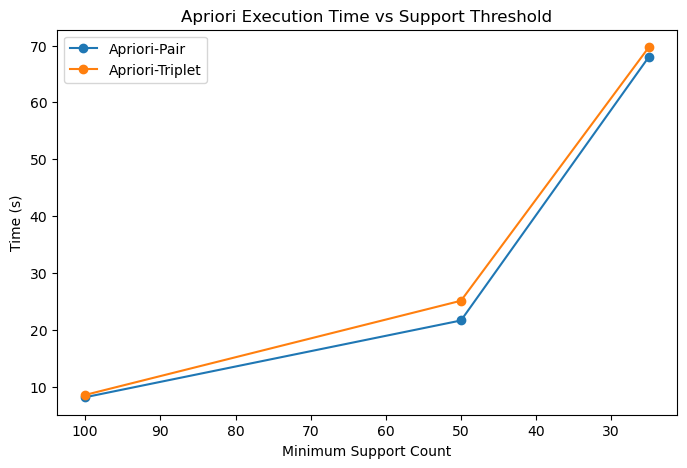

In [33]:
# Plotting
plt.figure(figsize=(8,5))
plt.plot(support_thresholds, apriori_pair_times, marker='o', label='Apriori-Pair')
plt.plot(support_thresholds, apriori_trip_times, marker='o', label='Apriori-Triplet')
plt.gca().invert_xaxis()
plt.title('Apriori Execution Time vs Support Threshold')
plt.xlabel('Minimum Support Count')
plt.ylabel('Time (s)')
plt.legend()
plt.show()

### 3.2

In [32]:
#Support thresholds: [100, 50, 25]
#FPGrowth-Pair: [22.56218120000267, 45.63684450000437, 81.91034560000116]
#FPGrowth-Triplet: [20.573556900002586, 70.18472289999772, 85.34841549999692]
#圖如下

沒有平行，FPGrowth-Triplet在Support thresholds 25反倒沒有繼續增加時間，有趨於平緩，推測受到FP-Growth不產生候選項目集合，因此顯著降低運算負擔，使得演算法更快速且具備更好的可擴展性。

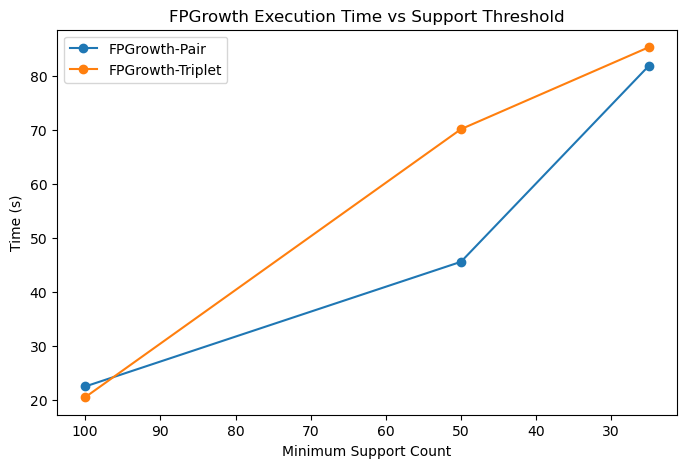

In [34]:


plt.figure(figsize=(8,5))
plt.plot(support_thresholds, fpg_pair_times, marker='o', label='FPGrowth-Pair')
plt.plot(support_thresholds, fpg_trip_times, marker='o', label='FPGrowth-Triplet')
plt.gca().invert_xaxis()
plt.title('FPGrowth Execution Time vs Support Threshold')
plt.xlabel('Minimum Support Count')
plt.ylabel('Time (s)')
plt.legend()
plt.show()


### 3.3  

問題 1：哪種演算法在支援度降低時，執行時間變化較小？
FP-Growth。

FP-Growth 在支援度降低時，時間增加幅度遠小於 Apriori。

問題 2：較平穩的趨勢是否表示較好的可擴展性？
是的！

趨勢越平穩，表示演算法面對資料量變大或門檻降低時，執行時間增加得越慢，代表可擴展性越好。

問題 3：兩種演算法各需掃描資料集幾次？

演算法	掃描資料次數
Apriori	每增加一個項目層級（2項、3項）就要重新掃描一次資料集。例：Pair要掃2次、Triplet要掃3次。
FP-Growth	固定只掃描資料集 2次：一次建 FP-Tree，一次從樹中挖掘頻繁項目。